In [1]:
import zipfile
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_colwidth", None)
from pipeline import Pipeline
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

/tmp/ipykernel_30289/1615766980.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
#extracting the zip file
with zipfile.ZipFile("./../data/books_data.zip", "r") as zip_ref:
    zip_ref.extractall("./../data/")

In [5]:
#loading data
ratings_data = pd.read_csv("./../data/Ratings.csv")
books_data = pd.read_csv("./../data/Books.csv")
users_data = pd.read_csv("./../data/Users.csv")
#rename column to enable .column
ratings_data, books_data, users_data = Pipeline.rename_columns(ratings_data, 
                                            books_data, users_data)
#drop img urls
books_data = Pipeline.remove_img_urls(books_data)
print(ratings_data.shape)
print(books_data.shape)
print(users_data.shape)
user_item_matrix_size = books_data.shape[0]*users_data.shape[0]
print("User matrix size: ",user_item_matrix_size)
print("Matrix sparsity: ", ratings_data.shape[0]/user_item_matrix_size," %")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# Ratings dataset cleaning/exploration

In [ ]:
ratings_data.describe()

,userID,bookRating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [ ]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
ratings_data.head(10)


,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


In [ ]:
ratings_data.isna().sum()

userID        0
ISBN          0
bookRating    0
dtype: int64

<Axes: >

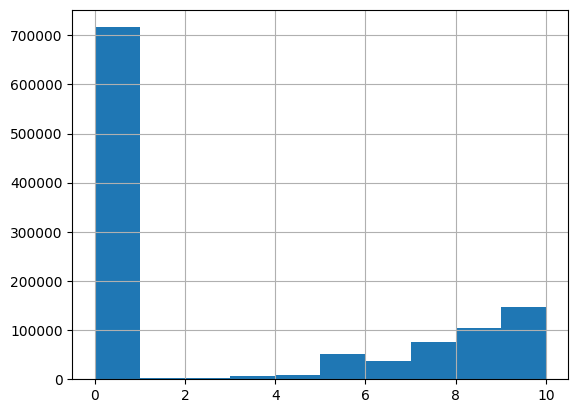

In [ ]:
ratings_data.bookRating.hist()

In [ ]:
implicit_count = len(ratings_data.loc[ratings_data.bookRating == 0])
explicit_count = len(ratings_data.loc[ratings_data.bookRating != 0])
print("Number of implicit feedbacks: ",implicit_count, " ~ ", 
    round(implicit_count/len(ratings_data),2),"%")
print("Number of explicit feedbacks: ", explicit_count, " ~ ",
    round(explicit_count/len(ratings_data),2),"%")

Number of implicit feedbacks:  716109  ~  0.62 %
Number of explicit feedbacks:  433671  ~  0.38 %


# Books dataset cleaning/exploration

In [ ]:
#we do not have much info about the books such as genres
books_data.head(10)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Historians Imagine What Might Have Been,Robert Cowley,2000,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks
8,0679425608,Under the Black Flag: The Romance and the Reality of Life Among the Pirates,David Cordingly,1996,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner


In [ ]:
#We have to fix dtypes
books_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271358 non-null  object
 3   yearOfPublication  271360 non-null  object
 4   publisher          271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [ ]:
#books_data.yearOfPublication = pd.to_numeric(books_data.yearOfPublication)
# => returns Unable to parse string "DK Publishing Inc" at position 209538

In [ ]:
def is_non_integer(value):
    return not isinstance(value, int)

In [ ]:
non_integer_values = books_data.yearOfPublication.apply(is_non_integer)

# Filter the DataFrame based on non-integer values
non_integer_df = books_data[non_integer_values]

In [ ]:
non_integer_df

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
196608,0425176967,Self-Portrait With Ghosts,Kelly Dwyer,2000,Berkley Publishing Group
196609,0373239971,"Baby'S First Christmas (The Baby Of The Month Club) (Silhouette Special Edition No, 997)",Marie Ferrarella,1995,Silhouette
196610,0373201613,Man She Married (By Request) (By Request),Ann Major,1999,Harlequin
196611,159071024X,The Gilded Chamber,Rebecca Kohn,2004,Rugged Land
196612,0066210747,"The Bielski Brothers: The True Story of Three Men Who Defied the Nazis, Saved 1,200 Jews and Built a Village in the Forest",Peter Duffy,2003,HarperCollins
...,...,...,...,...,...
262139,0897332032,"The Age of Agony: The Art of Healing, 1700-1800",Guy R. Williams,1986,Academy Chicago Publishers
262140,0897332857,The Age of Miracles,Guy Williams,1987,Academy Chicago Publishers
262141,0897333918,The Common Stream: Two Thousand Years of the English Village,Rowland Parker,1994,Academy Chicago Publishers
262142,0906540631,The Essene Odyssey: The Mystery of the True Teacher and the Essene Impact on the Shaping of Human Destiny,Hugh J. Schonfield,1993,Element Books


In [ ]:
books_data.loc[books_data.yearOfPublication == "DK Publishing Inc"]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [ ]:
#Taken from the recommendation notebook in the dataset description
books_data.loc[books_data.ISBN == '0789466953','yearOfPublication'] = 2000
books_data.loc[books_data.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books_data.loc[books_data.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books_data.loc[books_data.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
books_data.loc[books_data.ISBN == '078946697X','yearOfPublication'] = 2000
books_data.loc[books_data.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books_data.loc[books_data.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books_data.loc[books_data.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [ ]:
#Check the fix
books_data.loc[(books_data.ISBN == '0789466953') | (books_data.ISBN == '078946697X')]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc


In [ ]:
#books_data.yearOfPublication = pd.to_numeric(books_data.yearOfPublication)
# => returns Unable to parse string "Gallimard" at position 220731

In [ ]:
books_data.loc[books_data.yearOfPublication == "Gallimard"]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [ ]:
#Taken from the recommendation notebook in the dataset description
books_data.loc[books_data.ISBN == '2070426769','yearOfPublication'] = 2003
books_data.loc[books_data.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books_data.loc[books_data.ISBN == '2070426769','publisher'] = "Gallimard"
books_data.loc[books_data.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [ ]:
#Check fix
books_data.loc[books_data.ISBN == '2070426769']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [ ]:
#years fixed
books_data.yearOfPublication = pd.to_numeric(books_data.yearOfPublication)
books_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271358 non-null  object
 3   yearOfPublication  271360 non-null  int64 
 4   publisher          271358 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB


The recommendation notebook also suggests removing future values because the dataset was published in 2004 and keeping some margin to 2006

In [ ]:
#There was never year 0 just 1BC and 1 AD 
books_data.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984,    0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378,
       1919, 1922, 1897, 2024, 1376, 2037])

Mean imputing here is quite questionable it really depends whether we believe that these values are just typos or there can be some reason why is it such (then it might make sense to change values above 2006 to 2006 and 0 to 1 for instance) but without more info it is safer to relly on mean imputing

In [ ]:
books_data.loc[(books_data.yearOfPublication > 2006) | (books_data.yearOfPublication == 0),'yearOfPublication'] = np.NAN
books_data.yearOfPublication.fillna(round(books_data.yearOfPublication.mean()), inplace=True)

/tmp/ipykernel_130693/1320523922.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books_data.yearOfPublication.fillna(round(books_data.yearOfPublication.mean()), inplace=True)


In [ ]:
books_data.isna().sum()

ISBN                 0
bookTitle            0
bookAuthor           2
yearOfPublication    0
publisher            2
dtype: int64

In [ ]:
books_data.loc[(books_data.bookAuthor.isna()) | (books_data.publisher.isna())]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN
187689,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995.0,Edinburgh Financial Publishing


In [ ]:
books_data.loc[(books_data.bookAuthor.isna()), "bookAuthor"] = "unknown"
books_data.loc[(books_data.publisher.isna()), "publisher"] = "unknown"


In [ ]:
books_data.loc[(books_data.ISBN == "0751352497") | 
            (books_data.ISBN == "193169656X") | (books_data.ISBN == "1931696993") |
            (books_data.ISBN == "9627982032")]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
118033,0751352497,A+ Quiz Masters:01 Earth,unknown,1999.0,Dorling Kindersley
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,unknown
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,unknown
187689,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,unknown,1995.0,Edinburgh Financial Publishing


In [ ]:
# Removed all missing values
books_data.isna().sum()

ISBN                 0
bookTitle            0
bookAuthor           0
yearOfPublication    0
publisher            0
dtype: int64

In [ ]:
books_data.to_csv("./../data/books_filtered.csv")

In [ ]:
users_data.head(20)

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [ ]:
users_data[["City","Region","State"]] = users_data.Location.str.split(', ', expand=True).iloc[:,:3]

In [ ]:
users_data.isna().sum()

userID           0
Location         0
Age         110762
City             0
Region           1
State         4577
dtype: int64

In [ ]:
users_data.loc[users_data.Region.isna()]

,userID,Location,Age,City,Region,State
134376,134377,lawrenceville,30.0,lawrenceville,None,None


In [ ]:
users_data.loc[users_data.Region.isna(),["Region","State"]] = "georgia", "usa"

In [ ]:
# It would be possible to infer the region and state from similar entries in the dataset
# but I believe that it is relatively insignificant with only a few of these entries
users_data.loc[users_data.State.isna()]

,userID,Location,Age,City,Region,State
18,19,"weston, ,",14.0,weston,",",None
90,91,"toronto/newmarket, ,",NaN,toronto/newmarket,",",None
311,312,"lk, jlk,",NaN,lk,"jlk,",None
317,318,"berlin, n/a,",NaN,berlin,"n/a,",None
536,537,"davis, california,",NaN,davis,"california,",None
...,...,...,...,...,...,...
278624,278625,"savona, ,",36.0,savona,",",None
278651,278652,"murrieta, ,",NaN,murrieta,",",None
278697,278698,"pasadena, maryland,",NaN,pasadena,"maryland,",None
278716,278717,"mayagüez, puerto rico,",53.0,mayagüez,"puerto rico,",None


In [ ]:
users_data.loc[users_data.State.isna(),"State"] = "unknown"

In [ ]:
users_data.Region = users_data.Region.str.replace(",","unknown")
users_data.Region = users_data.Region.str.replace("n/a","unknown")

In [ ]:
# Removing location after splitting it
users_data.drop(["Location"],axis = 1, inplace = True)

In [ ]:
users_data

,userID,Age,City,Region,State
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,NaN,portland,oregon,usa
278854,278855,50.0,tacoma,washington,united kingdom
278855,278856,NaN,brampton,ontario,canada
278856,278857,NaN,knoxville,tennessee,usa


In [ ]:
len(users_data.Region.unique())

6661

<Axes: >

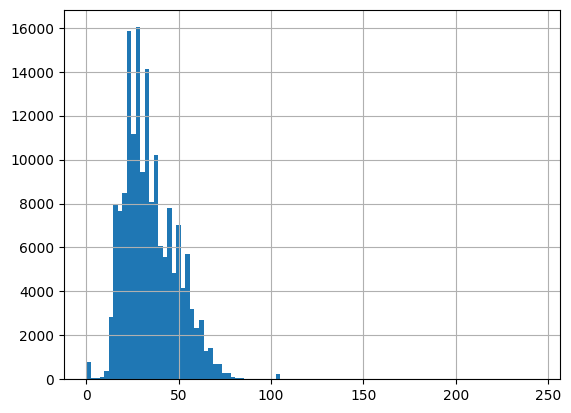

In [ ]:
#removing nonsense age 
users_data.Age.hist(bins=100)

In [ ]:
users_data

,userID,Age,City,Region,State
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,NaN,portland,oregon,usa
278854,278855,50.0,tacoma,washington,united kingdom
278855,278856,NaN,brampton,ontario,canada
278856,278857,NaN,knoxville,tennessee,usa


Here again questionable whether to treat the outliers same as the other NAs. But there is not that many of them so we will proceed with that for now

In [ ]:
users_data.loc[(users_data.Age > 100) | (users_data.Age < 2), "Age"] = np.nan


In [ ]:
users_data

,userID,Age,City,Region,State
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,NaN,portland,oregon,usa
278854,278855,50.0,tacoma,washington,united kingdom
278855,278856,NaN,brampton,ontario,canada
278856,278857,NaN,knoxville,tennessee,usa


In [ ]:
# Almost half of the ages are missing in the dataset => mean imputing might be suboptimal
users_data.isna().sum()
# For now skipping this step because 
# we will use the user-item matrix to do K-means imputing based on 
# the books the user reads

userID         0
Age       111832
City           0
Region         0
State          0
dtype: int64

# Creating User-item matrix to determine age with KNN

In [ ]:
# Mergin books and Users to ratings
#there are apparently some missing values in Users that are in the ratings => left join to not loose these information 
combined_data = ratings_data.merge(users_data, on = "userID", how="left")

In [ ]:
combined_data

,userID,ISBN,bookRating,Age,City,Region,State
0,276725,034545104X,0,NaN,tyler,texas,usa
1,276726,0155061224,5,NaN,seattle,washington,usa
2,276727,0446520802,0,16.0,h,new south wales,australia
3,276729,052165615X,3,16.0,rijeka,unknown,croatia
4,276729,0521795028,6,16.0,rijeka,unknown,croatia
...,...,...,...,...,...,...,...
1149775,276704,1563526298,9,NaN,cedar park,texas,usa
1149776,276706,0679447156,0,18.0,quebec,quebec,canada
1149777,276709,0515107662,10,38.0,mannington,west virginia,usa
1149778,276721,0590442449,10,14.0,providence,rhode island,usa


In [ ]:
combined_data.isna().sum()

userID             0
ISBN               0
bookRating         0
Age           314432
City               0
Region             0
State              0
dtype: int64

In [ ]:
combined_data = combined_data.merge(books_data, on = "ISBN")

In [ ]:
#there seem to be some rating that do not correspond to a book ISBN
#I had to change second merge to inner
combined_data.isna().sum()

userID                    0
ISBN                      0
bookRating                0
Age                  281734
City                      0
Region                    0
State                     0
bookTitle                 0
bookAuthor                0
yearOfPublication         0
publisher                 0
dtype: int64

In [ ]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   userID             1031136 non-null  int64  
 1   ISBN               1031136 non-null  object 
 2   bookRating         1031136 non-null  int64  
 3   Age                749402 non-null   float64
 4   City               1031136 non-null  object 
 5   Region             1031136 non-null  object 
 6   State              1031136 non-null  object 
 7   bookTitle          1031136 non-null  object 
 8   bookAuthor         1031136 non-null  object 
 9   yearOfPublication  1031136 non-null  float64
 10  publisher          1031136 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 86.5+ MB


In [ ]:
#user_item = combined_data.pivot_table(index = "userID", columns="bookTitle",values="bookRating",fill_value=0)
#the dataset seems to be too big for pivot

In [ ]:
len(combined_data)

1031136

In [ ]:
combined_data.userID.astype("category").cat.categories

Index([     2,      8,      9,     10,     12,     14,     16,     17,     19,
           20,
       ...
       278832, 278836, 278838, 278843, 278844, 278846, 278849, 278851, 278852,
       278854],
      dtype='int64', length=92106)

In [ ]:
combined_data.userID = combined_data.userID.astype("category")
combined_data.bookTitle = combined_data.bookTitle.astype("category")

In [ ]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   userID             1031136 non-null  category
 1   ISBN               1031136 non-null  object  
 2   bookRating         1031136 non-null  int64   
 3   Age                749402 non-null   float64 
 4   City               1031136 non-null  object  
 5   Region             1031136 non-null  object  
 6   State              1031136 non-null  object  
 7   bookTitle          1031136 non-null  category
 8   bookAuthor         1031136 non-null  object  
 9   yearOfPublication  1031136 non-null  float64 
 10  publisher          1031136 non-null  object  
dtypes: category(2), float64(2), int64(1), object(6)
memory usage: 91.3+ MB


In [ ]:
combined_data.userID.describe()

count     1031136
unique      92106
top         11676
freq        11144
Name: userID, dtype: int64

In [ ]:
users = combined_data["userID"].unique()
book_titles = combined_data["bookTitle"].unique()
shape = (len(users), len(book_titles))
coo = scipy.sparse.coo_matrix((combined_data.bookRating, 
                    (combined_data.userID.cat.codes, 
                combined_data.bookTitle.cat.codes)), shape=shape)
csr = coo.tocsr()


In [ ]:
print("Number of unique users: ", len(users))
print("Number of unique book titles: ", len(book_titles))

Number of unique users:  92106
Number of unique book titles:  241071


In [ ]:
combined_data.head()

,userID,ISBN,bookRating,Age,City,Region,State,bookTitle,bookAuthor,yearOfPublication,publisher
0,276725,034545104X,0,NaN,tyler,texas,usa,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books
1,276726,0155061224,5,NaN,seattle,washington,usa,Rites of Passage,Judith Rae,2001.0,Heinle
2,276727,0446520802,0,16.0,h,new south wales,australia,The Notebook,Nicholas Sparks,1996.0,Warner Books
3,276729,052165615X,3,16.0,rijeka,unknown,croatia,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press
4,276729,0521795028,6,16.0,rijeka,unknown,croatia,The Amsterdam Connection : Level 4 (Cambridge English Readers),Sue Leather,2001.0,Cambridge University Press


In [ ]:
#to speed up the computation we will compute the age for each person in that made a review
combined_no_duplicates = combined_data.drop_duplicates(subset=["userID"])

In [ ]:
combined_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92106 entries, 0 to 1031135
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   userID             92106 non-null  category
 1   ISBN               92106 non-null  object  
 2   bookRating         92106 non-null  int64   
 3   Age                53566 non-null  float64 
 4   City               92106 non-null  object  
 5   Region             92106 non-null  object  
 6   State              92106 non-null  object  
 7   bookTitle          92106 non-null  category
 8   bookAuthor         92106 non-null  object  
 9   yearOfPublication  92106 non-null  float64 
 10  publisher          92106 non-null  object  
dtypes: category(2), float64(2), int64(1), object(6)
memory usage: 20.3+ MB


I have found out that I made a mistake doing the user-item matrix with userid-title because there are multiple published versions of the book with the same title. However I believe that it is not entirely problematic for age imputing as essentially what will happen is that the ratings from all the versions would end up on the same book which is reasonable for age determining

In [ ]:
category_to_code = {category: code for code, category in enumerate(combined_data.userID.cat.categories)}
#prefitting the model to pass it to the imputer (does not help much since inference in KNN is time heavy)
#using 1 just for demonstration and speed purpouses
nn_model = NearestNeighbors(n_neighbors=1, algorithm="auto",
                            metric="cosine")
nn_model.fit(csr)
combined_no_duplicates.Age = combined_no_duplicates.apply(Pipeline.knn_age_imputing, axis = 1, 
    args=(csr, combined_data.userID.cat.categories, users_data, category_to_code, nn_model))

/tmp/ipykernel_130693/352610953.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_no_duplicates.Age = combined_no_duplicates.apply(Pipeline.knn_age_imputing, axis = 1,


In [ ]:
combined_no_duplicates.loc[combined_no_duplicates.isna().any(axis = 1)]
#imputing mean to the missing values
combined_no_duplicates.loc[:,"Age"].fillna(str(int(users_data.Age.mean())))

0            34
1            34
2          16.0
3          16.0
5          37.0
           ... 
1031107    43.0
1031116      34
1031133    18.0
1031134    38.0
1031135    14.0
Name: Age, Length: 92106, dtype: object

In [ ]:
age_mapping = dict(zip(combined_no_duplicates.userID,combined_no_duplicates.Age))

In [ ]:
combined_data.Age = combined_data.Age.fillna(combined_data.userID.map(age_mapping))

In [ ]:
#The dataset is completely clean and we can save it 
combined_data.isna().sum()

userID               0
ISBN                 0
bookRating           0
Age                  0
City                 0
Region               0
State                0
bookTitle            0
bookAuthor           0
yearOfPublication    0
publisher            0
dtype: int64

In [ ]:
# serialize the data
combined_data.to_csv("./../data/merged_data.csv")

In [2]:
Pipeline.create_item_item_similarity_mapping()

95790
(1035, 1634)
(1035, 1634)


Since there seems to be a problem with sparsity I will have to probably reconsider the size of the matrix and reduce the number of users/books potentially both

/tmp/ipykernel_111202/2350955998.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_data.groupby("userID")["bookRating"].count().plot()


<Axes: xlabel='userID'>

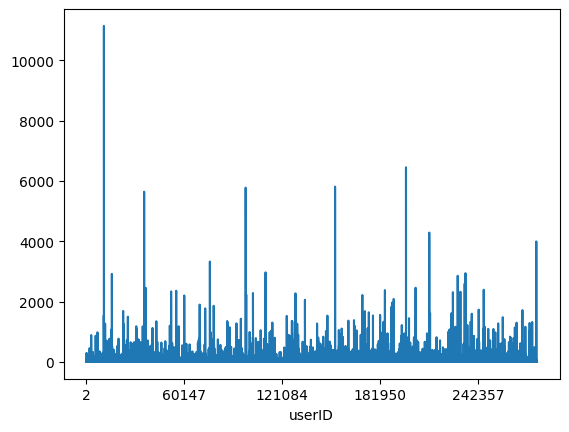

In [ ]:
combined_data.groupby("userID")["bookRating"].count().plot()

In [ ]:
len(combined_data)

642765

# Testing subsetting for dimensionality reduction

In [8]:
combined_data = pd.read_csv("./../data/merged_data.csv")

In [9]:

# Reducing number of users
users_high = combined_data.groupby("userID").count()["bookRating"] > 50
ids_high = users_high[users_high].index.tolist()
combined_data = combined_data.loc[combined_data.userID.isin(ids_high)].copy()

In [37]:
combined_data.groupby("userID").count()["bookRating"]

userID
243         79
254        300
507        129
638         73
643         56
          ... 
278188     194
278418    3996
278582      60
278633      73
278843      60
Name: bookRating, Length: 3012, dtype: int64

In [10]:
books_high = combined_data.groupby("bookTitle").count()["bookRating"] > 50
books_ids_high = books_high[books_high].index.tolist()
combined_data = combined_data.loc[combined_data.bookTitle.isin(
    books_ids_high)].copy()

In [11]:
combined_data.sort_values(by="bookTitle")

,Unnamed: 0,userID,ISBN,bookRating,Age,City,Region,State,bookTitle,bookAuthor,yearOfPublication,publisher
847661,847661,229313,0451519841,0,31.0,southgate,michigan,usa,1984,George Orwell,1980.0,New Amer Library
798728,798728,215942,207036822X,0,24.0,toulouse,midi-pyrénées,france,1984,George Orwell,1994.0,Gallimard French
200023,200023,52350,0451524934,0,31.0,lisboa,unknown,portugal,1984,George Orwell,1990.0,Signet Book
372259,372259,98787,0451524934,0,26.0,melbourne,victoria,australia,1984,George Orwell,1990.0,Signet Book
448913,448913,121251,0451524934,10,41.0,galt,california,usa,1984,George Orwell,1990.0,Signet Book
...,...,...,...,...,...,...,...,...,...,...,...,...
467660,467660,126604,0805059555,0,27.0,north reading,massachusetts,usa,"\O\"" Is for Outlaw""",Sue Grafton,1999.0,Henry Holt &amp; Company
997938,997938,266807,0805059555,0,35.0,tustin,california,usa,"\O\"" Is for Outlaw""",Sue Grafton,1999.0,Henry Holt &amp; Company
721493,721493,196077,0449003787,0,28.0,disputanta,virginia,usa,"\O\"" Is for Outlaw""",SUE GRAFTON,2001.0,Ballantine Books
158843,158843,38556,0449003787,0,34.0,edmonton,alberta,canada,"\O\"" Is for Outlaw""",SUE GRAFTON,2001.0,Ballantine Books


In [50]:
combined_data["bookTitle"].value_counts().sort_values(ascending=False)[:30]

bookTitle
Wild Animus                                           772
The Lovely Bones: A Novel                             555
The Da Vinci Code                                     433
Bridget Jones's Diary                                 430
The Nanny Diaries: A Novel                            392
A Painted House                                       380
Divine Secrets of the Ya-Ya Sisterhood: A Novel       379
The Secret Life of Bees                               379
The Notebook                                          372
The Firm                                              356
The Pelican Brief                                     349
Life of Pi                                            346
Snow Falling on Cedars                                342
Angels &amp; Demons                                   340
The Red Tent (Bestselling Backlist)                   335
A Time to Kill                                        334
The Joy Luck Club                                     311
Summ

# Small test with pivot table to troubleshoot error in pipeline

In [54]:
pivot = combined_data.pivot_table(index = "bookTitle",columns="userID",values="bookRating")
pivot.fillna(0, inplace=True)


In [55]:
nn_model = NearestNeighbors(n_neighbors=5, algorithm="brute",
                            metric="cosine", n_jobs=-1)
nn_model.fit(pivot)
_, nearest_neighbors = nn_model.kneighbors(pivot)

In [81]:
nearest_neighbors

array([[   0,   89,  153,   75, 1198],
       [   1,  689,   73,  515,  748],
       [   2,  406,  975,  190,  297],
       ...,
       [1326,   14,  710,  103,  453],
       [1327,  503,  350,  590, 1126],
       [1328,  667,  493,  162,  328]])

In [59]:
combined_data.bookTitle = combined_data.bookTitle.astype("category")

In [60]:
cat_nearest_books = pd.Categorical.from_codes(nearest_neighbors,
                                            categories=combined_data.bookTitle.cat.categories)